# Prepare your image data

## Load data from your drive 

### When you test on remote dataset of 101_ObjectCategories.tar.gz

1. Download `101_ObjectCategories` data_set direcly

In [ ]:
!wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz

2. Extract data using the following functions 

In [ ]:
filename_remote = "101_ObjectCategories.tar.gz"
extractFolderName_remote = "101_ObjectCategories"
url_remote = "http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz"

### When you test on dataset of your own(ex. Here "traffic_3class.zip" in google drive)

[Note]: Compressed files（.zip, .tar, .tar.gz）  
*Change the `"data_drive_path"` of yours

In [2]:
# root_path of your dataFile in drive(don't forget the last '/')
data_drive_path = "/content/drive/MyDrive/ImageSimilar/data/"
filename_drive = "traffic_3class.zip"
extractFolderName_drive = "traffic_3class"

### Extract data file functions(Local drive/Remote)

In [3]:
import os.path
import urllib.request
import tarfile
import zipfile
import gzip
from shutil import copy

def fetch_remote_datafile(filename, remote_url):
  if os.path.isfile("./" + filename):
    print("already have " + filename + " in workspace")
    return
  print("fetching " + filename + " from " + remote_url + "...")
  # url: remote url to get data
  # filename: local filename to save the data 
  urllib.request.urlretrieve(remote_url, "./" + filename)

def cache_datafile_in_drive(filename):
  if os.path.isfile("./" + filename) == False:
    print("cannot cache " + filename + ", it is not in workspace")
    return
  if os.path.isfile(data_drive_path + filename):
    print("" + filename + " has already been stored in Google Drive")
  else:
    print("copying " + filename + " to " + data_drive_path)
    copy("./" + filename, data_drive_path)
  
# From your drive path
def load_dataFile_from_drive(filename, remote_url=None):
  # Check the VM workspace of colab(/content/)
  if os.path.isfile("./" + filename):
    print("already have " + filename + " in workspace")
  elif os.path.isfile(data_drive_path + filename):
    print("have " + filename + " in Google Drive, copying to workspace...")
    copy(data_drive_path + filename, ".")
  elif remote_url != None:
    print("get file from remote URL!")
    fetch_remote_datafile(filename, remote_url)
  else:
    print("error: you need to manually download " + filename + " and put in drive")
    
def extract_datafile(filename, expected_extract_artifact=None):
  if expected_extract_artifact != None and (os.path.isfile(expected_extract_artifact) or os.path.isdir(expected_extract_artifact)):
    print("files in " + filename + " have already been extracted")
  elif os.path.isfile("./" + filename) == False:
    print("error: cannot extract " + filename + ", it is not in the workspace")
  else:
    extension = filename.split('.')[-1]
    if extension == "zip":
      print("extracting " + filename + "...")
      data_file = open(filename, "rb")
      z = zipfile.ZipFile(data_file)
      for name in z.namelist():
          print("    extracting file", name)
          z.extract(name, "./")
      data_file.close()
    elif extension == "gz":
      print("extracting " + filename + "...")
      if filename.split('.')[-2] == "tar":
        tar = tarfile.open(filename)
        tar.extractall()
        tar.close()
      else:
        data_zip_file = gzip.GzipFile(filename, 'rb')
        data = data_zip_file.read()
        data_zip_file.close()
        extracted_file = open('.'.join(filename.split('.')[0:-1]), 'wb')
        extracted_file.write(data)
        extracted_file.close()
    elif extension == "tar":
      print("extracting " + filename + "...")
      tar = tarfile.open(filename)
      tar.extractall()
      tar.close()
    elif extension == "csv":
      print("do not need to extract csv")
    else:
      print("cannot extract " + filename)
      
def load_cache_extract_datafile(filename, expected_extract_artifact=None, remote_url=None):
  load_dataFile_from_drive(filename, remote_url)
  extract_datafile(filename, expected_extract_artifact)
  cache_datafile_in_drive(filename)

Load data from remote

In [ ]:
load_cache_extract_datafile(filename_remote, extractFolderName_remote, url_remote)

Load from your local drive

In [4]:
load_cache_extract_datafile(filename_drive, extractFolderName_drive)

have traffic_3class.zip in Google Drive, copying to workspace...
extracting traffic_3class.zip...
    extracting file traffic_3class/
    extracting file traffic_3class/.DS_Store
    extracting file __MACOSX/traffic_3class/._.DS_Store
    extracting file traffic_3class/car1_reference/
    extracting file traffic_3class/bus0_reference/
    extracting file traffic_3class/car0_reference/
    extracting file traffic_3class/car1_reference/car1_1.png
    extracting file __MACOSX/traffic_3class/car1_reference/._car1_1.png
    extracting file traffic_3class/car1_reference/car1_0.png
    extracting file __MACOSX/traffic_3class/car1_reference/._car1_0.png
    extracting file traffic_3class/car1_reference/car1_2.png
    extracting file __MACOSX/traffic_3class/car1_reference/._car1_2.png
    extracting file traffic_3class/car1_reference/car1_3.png
    extracting file __MACOSX/traffic_3class/car1_reference/._car1_3.png
    extracting file traffic_3class/car1_reference/car1_4.png
    extracting file

In [5]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [6]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15754024802188884802, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4139897240300726451
 physical_device_desc: "device: XLA_CPU device"]

In [7]:
import requests
import os
import numpy as np
from numpy.linalg import norm
import joblib as pickle
from tqdm import tqdm
import os
import PIL
import time
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
#from tensorflow.keras.applications.MobileNet import MobileNetV2,preprocess_input
#from tensorflow.keras.applications.mobilenet import MobileNet,preprocess_input
import math
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import PCA

# Create Resnet50 model without top layers(trained on imageNet)

Get convolutional features(2048 dimension) as output instead of the image classification probability.

In [8]:
img_size =224
model = ResNet50(weights='imagenet', include_top=False,input_shape=(img_size, img_size, 3),pooling='max')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
94773248/94765736 [==============================] - 2s 0us/step


# Create the keras image data generator object

1. All image file in one folder
2. Images are saved in separate folders according to category

`[Note]` *Change your root path

In [9]:
batch_size = 5

root_dir = "./traffic_3class/"

# Images are saved in separate folders according to category
#root_dir = "./101_ObjectCategories"

img_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# 1. All image file in one folder(classes=['foldername'])
'''
datagen = img_gen.flow_from_directory(root_dir,
                                        target_size=(img_size, img_size),
                                        batch_size=batch_size,
                                        classes=['traffic_img'],
                                        class_mode=None,
                                        shuffle=False)
'''

# 2. Images are saved in separate folders according to category

datagen = img_gen.flow_from_directory(root_dir,
                                        target_size=(img_size, img_size),
                                        batch_size=batch_size,
                                        class_mode=None,
                                        shuffle=False)


num_images = len(datagen.filenames)
num_epochs = int(math.ceil(num_images / batch_size))

print("Num images   = ", len(datagen.classes))
# Get full path for all the images in our dataset
filenames = [root_dir + s for s in datagen.filenames]
print(filenames)

Found 15 images belonging to 3 classes.
Num images   =  15
['./traffic_3class/bus0_reference/bus0_0.png', './traffic_3class/bus0_reference/bus0_1.png', './traffic_3class/bus0_reference/bus0_2.png', './traffic_3class/bus0_reference/bus0_3.png', './traffic_3class/bus0_reference/bus0_4.png', './traffic_3class/car0_reference/car0_0.png', './traffic_3class/car0_reference/car0_1.png', './traffic_3class/car0_reference/car0_2.png', './traffic_3class/car0_reference/car0_3.png', './traffic_3class/car0_reference/car0_4.png', './traffic_3class/car1_reference/car1_0.png', './traffic_3class/car1_reference/car1_1.png', './traffic_3class/car1_reference/car1_2.png', './traffic_3class/car1_reference/car1_3.png', './traffic_3class/car1_reference/car1_4.png']


# Extract the convolutional features for every images 

Using Resnet50 predict_generator method to exract the features for images in dataset(num_images, 2048)

In [10]:
feature_list = model.predict_generator(datagen, num_epochs)
print("Shape of feature_list = ", feature_list.shape)

Shape of feature_list =  (15, 2048)


# Fit the nearest neighbor algorithm to the extracted features

We have picked ball_tree algorithm as it works well with sparse data.

In [11]:
neighbors = NearestNeighbors(n_neighbors=15, algorithm='ball_tree', metric='euclidean')
#neighbors = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='cosine')
#neighbors = NearestNeighbors(n_neighbors=3, algorithm='auto', metric='minkowski')
neighbors.fit(feature_list)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                 radius=1.0)

# Find similar images for a new image

## Test image preprocess

In [13]:
img_path = 'detectedcar_test.png'
input_shape = (img_size, img_size, 3)
img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array)


## Extract convolutional feature of test image

In [14]:
test_img_features = model.predict(preprocessed_img, batch_size=1)
print(test_img_features.shape)
distances, indices = neighbors.kneighbors(test_img_features, n_neighbors=15, return_distance=True)

print(distances)
print(indices)

(1, 2048)
[[131.43792931 140.49698265 153.42035706 166.73277559 182.09691013
  185.63983082 189.7129977  191.82937873 192.25987665 197.71768958
  221.03544713 229.62233581 235.61044313 242.67761478 249.4392566 ]]
[[ 5  8  7  6 13 12 10 14  9 11  0  1  2  4  3]]


## Show the results(ranking and distances)

(1, 15)


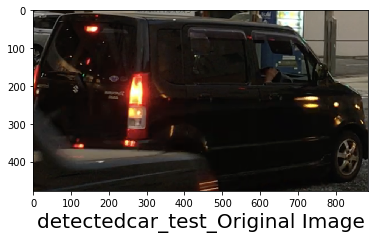

********* Predictions ***********


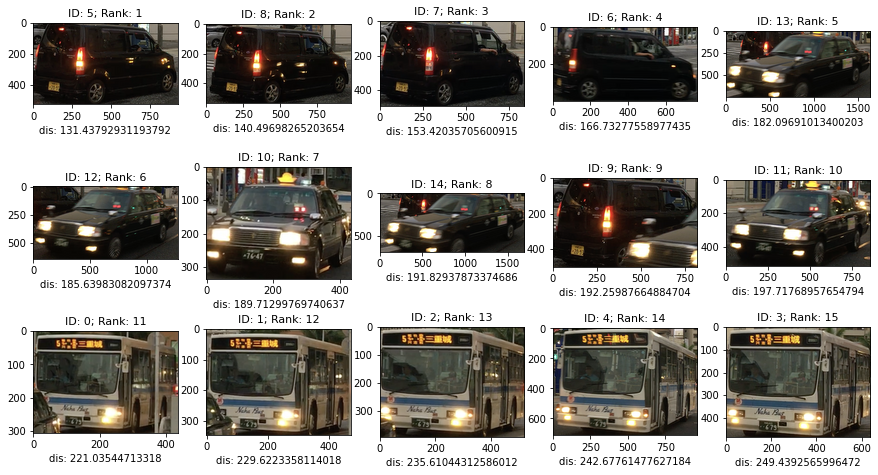

In [15]:
def similar_images(indices):
    fig=plt.figure(figsize=(15,10), facecolor='white')
    plotnumber = 1    
    for index in indices:
        if plotnumber<=len(indices) :
            ax = plt.subplot(3,5,plotnumber)
            ax.set_title('ID: ' + (str)(index) + '; Rank: ' + (str)(plotnumber), fontsize=11)
            plt.imshow(mpimg.imread(filenames[index]), interpolation='lanczos')
            plt.xlabel('dis: ' + (str)(distances[0][plotnumber-1]), fontsize=10)

            plotnumber+=1
            
    plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.7,
                wspace=0.2, hspace=0.4)
    #plt.tight_layout()
    #fig.tight_layout()

print(indices.shape)

plt.imshow(mpimg.imread(img_path), interpolation='none')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print('********* Predictions ***********')
similar_images(indices[0])

# Apply PCA to our features and reduce the dimensions.

We can see that image a of "Rank:5" in the prediction which is incorrect. Due to the large dimensionality of the features, the NearestNeighbors algorithm is not able to cluster similar features accurately(ranking).[Curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality)

## Re-extract the new feature using PCA

Reducing the dimensionality of features

In [16]:
# The number of principal components is more appropriately set to the number of categories
pca = PCA(n_components=3)
pca.fit(feature_list)
compressed_features = pca.transform(feature_list)

## Fit the nearest neighbor algorithm to the new features

In [19]:
neighbors_pca_features = NearestNeighbors(n_neighbors=15,
                             algorithm='ball_tree',
                             metric='euclidean').fit(compressed_features)

## Show the new results(ranking and distances)

(1, 15)
[[ 22.53949037  41.47426028  42.70484362  44.65572545  74.74772829
  114.61489494 124.12490104 124.17981391 136.10562523 140.92574336
  162.97288793 178.54351657 193.31221715 193.43545072 205.25482637]]
[[ 5  8  7  6 13 12 10 14  9 11  0  1  2  4  3]]


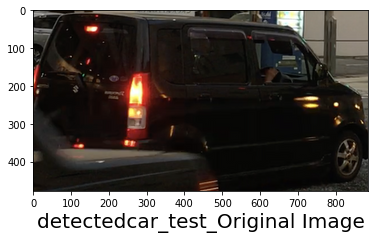

********* Predictions ***********


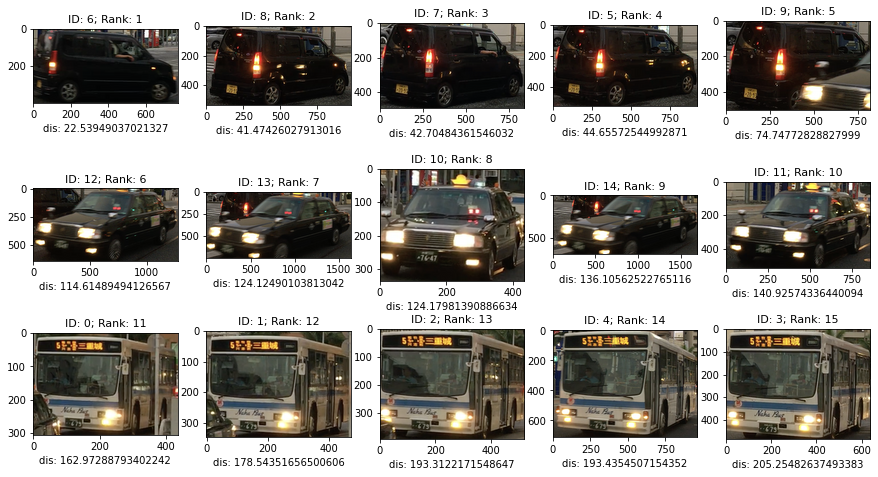

In [18]:
test_img_compressed = pca.transform(test_img_features)
distances, indices_PCA = neighbors_pca_features.kneighbors(test_img_compressed)
print(indices.shape)
print(distances)
print(indices)
plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print('********* Predictions ***********')
similar_images(indices_PCA[0])